In [1]:
import sys
sys.path.append('../../')

In [2]:
from functools import partial
from tqdm import trange
from typing import Dict

import numpy as np
import jax

import matplotlib.pyplot as plt
import jax.numpy as jnp

In [3]:
import flax
import flax.linen as nn
from flax.training.train_state import TrainState
import optax
import e3nn_jax as e3nn
from flax.training import checkpoints
from pathlib import Path



from models.gnn import GNN
from models.segnn import SEGNN
from models.utils.graph_utils import build_graph

2024-05-23 10:05:56.559100: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:

from dataset_large import get_halo_dataset

In [5]:

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate    

In [6]:
from models.utils.graph_utils import get_apply_pbc
from models.gnn import GNN
from models.segnn import SEGNN


from models.utils.graph_utils import build_graph
from models.utils.equivariant_graph_utils import get_equivariant_graph


In [7]:
import scienceplots
plt.style.use('science')

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [8]:

training_set_size = 15_000  

In [9]:
features = ['x', 'y', 'z', 'vx', 'vy', 'vz']  # ['x', 'y', 'z', 'Jx', 'Jy', 'Jz', 'vx', 'vy', 'vz', 'M200c']
batch_size = 64

tfrecords_path = '/pscratch/sd/c/cuesta/equivariance/bsq'

dataset, num_total, mean, std, mean_params, std_params = get_halo_dataset(
    tfrecords_path=tfrecords_path,
    batch_size=batch_size,  
    num_samples=training_set_size,  
    split='train',  
    return_mean_std=True,  
    features=features,
)
std = np.array(std)
train_iterator = iter(dataset)
x_train, _ = next(train_iterator)


val_batch_size = 16
# predict some velocities
val_dataset, _ = get_halo_dataset(
    batch_size=val_batch_size,
    tfrecords_path=tfrecords_path,
    num_samples=250, 
    split='val',
    features=features,  
    )
val_iterator = iter(val_dataset)

2024-05-23 10:06:22.726011: W external/local_xla/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:510] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  /usr/local/cuda-12.3
  /usr/local/cuda
  /global/homes/c/cuesta/.conda/envs/jax_env/lib/python3.9/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /global/homes/c/cuesta/.conda/envs/jax_env/lib/python3.9/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  For most apps, setting the environment variable XLA_FLAGS=--xla_gpu_cuda_data_dir=/path/to/cuda will work.


In [10]:
x_val, _ = next(val_iterator)
print(x_val.shape)

(16, 5000, 6)


In [11]:
boxsize = 1000.
use_pbcs = True
apply_pbc = get_apply_pbc(std=std / boxsize,) if use_pbcs else None
k = 10
n_radial = 0 
position_features = True
use_3d_distances = False 
r_max = 0.6
l_max = 1
infill_value = -2.

In [12]:
d_hidden = 128
n_layers = 3
message_passing_steps = 3
message_passing_agg = 'sum'
activation = 'gelu'
readout_agg = 'mean'
mlp_readout_widths = (4, 2, 2)
residual = True
GNN_PARAMS = {
    "d_hidden": d_hidden,
    "n_layers": n_layers,
    "message_passing_steps": message_passing_steps,
    "message_passing_agg": message_passing_agg,
    "activation": activation,
    "norm": "none",
    "task": "node",
    "n_outputs": 3,
    "readout_agg": "mean",
    "mlp_readout_widths": mlp_readout_widths,
    "position_features": True,
    "residual": residual,
}
SEGNN_PARAMS = {
    "d_hidden": d_hidden,
    "n_layers": n_layers,
    "message_passing_steps": message_passing_steps,
    "message_passing_agg": message_passing_agg,
    "scalar_activation": activation,
    "gate_activation": "sigmoid",
    "task": "node",
    "output_irreps": e3nn.Irreps("1x1o"),
    "readout_agg": "mean",
    "mlp_readout_widths": mlp_readout_widths,
    "l_max_hidden": 1,
    "hidden_irreps": None,
    "residual": residual,
}
    
class GraphWrapperGNN(nn.Module):
    param_dict: Dict
    @nn.compact
    def __call__(self, x):
        return jax.vmap(GNN(**self.param_dict))(x)
    

gnn = GraphWrapperGNN(GNN_PARAMS, )

In [13]:

class GraphWrapper(nn.Module):
    param_dict: Dict

    @nn.compact
    def __call__(self, x):

        positions = e3nn.IrrepsArray("1o", x.nodes[..., :3])
        
        if x.nodes.shape[-1] == 3:
            nodes = e3nn.IrrepsArray("1o", x.nodes[..., :])
        else:
            nodes = e3nn.IrrepsArray("1o + 1o", x.nodes[..., :])
        st_graph = get_equivariant_graph(
            node_features=nodes,
            positions=positions,
            velocities=None,
            steerable_velocities=False,
            senders=x.senders,
            receivers=x.receivers,
            n_node=x.n_node,
            n_edge=x.n_edge,
            globals=x.globals,
            edges=None,
            lmax_attributes=l_max,
            apply_pbc=apply_pbc,
            n_radial_basis=n_radial,
            r_max=r_max,
        )
        
        return jax.vmap(SEGNN(**self.param_dict))(st_graph)
segnn_model = GraphWrapper(SEGNN_PARAMS, )



In [14]:
SEGNN_PARAMS_l2 = SEGNN_PARAMS.copy()
SEGNN_PARAMS_l2['l_max_hidden'] = 2
segnn_model_lmax2 = GraphWrapper(SEGNN_PARAMS_l2, )


In [15]:
fixed_build_graph = lambda x: build_graph(
    x,
    None, 
    k=k, 
    apply_pbc=apply_pbc,
    use_edges=True, 
    n_radial_basis=n_radial,
    r_max=r_max,
    use_3d_distances=use_3d_distances,
)

In [16]:
def loss_mse(pred_batch, halo_batch, mask):
    # Only compute MSE based on mask (values which are 1)
    if isinstance(pred_batch, e3nn.IrrepsArray):
        pred_batch = pred_batch.array  # Euclidean distance is preserved by MSE, so we are safe doing this
    return jnp.sum(
        jnp.where(
            mask, 
            (pred_batch - halo_batch[..., 3:6]) ** 2, 
            0.)
        ) / jnp.sum(mask)

@partial(jax.pmap, axis_name="batch",)
def train_step(state, halo_batch_masked, halo_batch, mask):

    # Set those velocities in x_batch (only indices 3:6 of last dimension of x_batch) to 0
    halo_graph = fixed_build_graph(
        halo_batch_masked,
    )

    def loss_fn(params):
        outputs = state.apply_fn(params, halo_graph)
        loss = loss_mse(outputs.nodes, halo_batch, mask)
        return loss

    # Get loss, grads, and update state
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    grads = jax.lax.pmean(grads, "batch")
    new_state = state.apply_gradients(grads=grads)
    metrics = {"loss": jax.lax.pmean(loss, "batch")}
    
    return new_state, metrics

In [17]:
def initialize_state(model, graph, n_steps):
    lr = optax.cosine_decay_schedule(3e-4, n_steps)
    tx = optax.adamw(learning_rate=lr, weight_decay=1e-5)
    _, params = model.init_with_output(jax.random.PRNGKey(0), graph)
    state = TrainState.create(apply_fn=model.apply, params=params, tx=tx)
    return state

In [18]:



def train_model(train_iterator, model, n_steps=2000, fraction_masked=0.1,num_local_devices=1,save_model=False,ckpt_dir=Path('velocity_task')):    
    x_train, _ = next(train_iterator)
    graph = fixed_build_graph(
        jnp.array(x_train[:2]), 
    )
    state = initialize_state(model, graph, n_steps=n_steps)
    pstate = replicate(state)
    # Number of parameters
    print(f"Number of parameters: {sum([p.size for p in jax.tree.leaves(state.params)])}")
    key = jax.random.PRNGKey(0)
    train_loss = []
    with trange(n_steps) as steps:
        for step in steps:
            key, subkey = jax.random.split(key)
            x_batch, _ = next(train_iterator)
            x_batch = jnp.array(x_batch)
            mask = jax.random.bernoulli(
                key,
                fraction_masked, 
                shape=(len(x_batch), x_batch.shape[1], 1),
            )
            # Set those velocities in x_batch (indices 3:6 of last dimension) to 0
            x_batch_masked = x_batch.at[:, :, 3:6].set(
                jnp.where(mask, infill_value, x_batch[:, :, 3:6])
            )
            # Split batches across devices
            x_batch_masked = jax.tree.map(lambda x: np.split(x, num_local_devices, axis=0), x_batch_masked)
            x_batch_masked = jnp.array(x_batch_masked)

            x_batch = jax.tree.map(lambda x: np.split(x, num_local_devices, axis=0), x_batch)
            x_batch = jnp.array(x_batch)

            mask = jax.tree.map(lambda x: np.split(x, num_local_devices, axis=0), mask)
            mask = jnp.array(mask)

            pstate, metrics = train_step(pstate, x_batch_masked, x_batch, mask)

            loss = unreplicate(metrics["loss"])
            train_loss.append(loss)
            
            steps.set_postfix(loss=loss)
    pstate = unreplicate(pstate)
    if save_model:
        ckpt_dir.mkdir(parents=True, exist_ok=True)
        checkpoints.save_checkpoint(ckpt_dir=str(ckpt_dir), target=pstate, step=step, overwrite=True,)
        np.save(f'{ckpt_dir}/train_loss.npy', train_loss)
    return train_loss, pstate.params 

In [19]:
n_steps = 2000
fraction_masked = 0.1
num_local_devices = jax.local_device_count()

In [20]:


# train_loss_segnn, params_segnn = train_model(
#     train_iterator, 
#     segnn_model, 
#     n_steps=n_steps, 
#     fraction_masked=fraction_masked, 
#     num_local_devices=num_local_devices,
#     save_model=True,
#     ckpt_dir=Path(f'/global/u1/c/cuesta/eqnn-jax/benchmarks/galaxies/velocity_task/segnn_{training_set_size}'),
# )

In [21]:


# train_loss_gnn, params_gnn = train_model(
#     train_iterator, 
#     gnn, 
#     n_steps=n_steps, 
#     fraction_masked=fraction_masked, 
#     num_local_devices=num_local_devices,
#     save_model=True,
#     ckpt_dir=Path(f'/global/u1/c/cuesta/eqnn-jax/benchmarks/galaxies/velocity_task/gnn_{training_set_size}'),
# )

In [22]:
import numpy as np
import matplotlib.pyplot as plt
train_loss_segnn = np.load(f'/global/u1/c/cuesta/eqnn-jax/benchmarks/galaxies/velocity_task/segnn_{training_set_size}/train_loss.npy')
train_loss_segnn_lmax2 = np.load(f'/global/u1/c/cuesta/eqnn-jax/benchmarks/galaxies/velocity_task/segnn_lmax2_{training_set_size}/train_loss.npy')
train_loss_gnn = np.load(f'/global/u1/c/cuesta/eqnn-jax/benchmarks/galaxies/velocity_task/gnn_{training_set_size}/train_loss.npy')

In [23]:
# train_loss_segnn_lmax2, params_segnn_lmax2 = train_model(
#     train_iterator, 
#     segnn_model_lmax2, 
#     n_steps=n_steps, 
#     fraction_masked=fraction_masked, 
#     num_local_devices=num_local_devices,
#     save_model=True,
#     ckpt_dir=Path(f'/global/u1/c/cuesta/eqnn-jax/benchmarks/galaxies/velocity_task/segnn_lmax2_{training_set_size}'),
# )

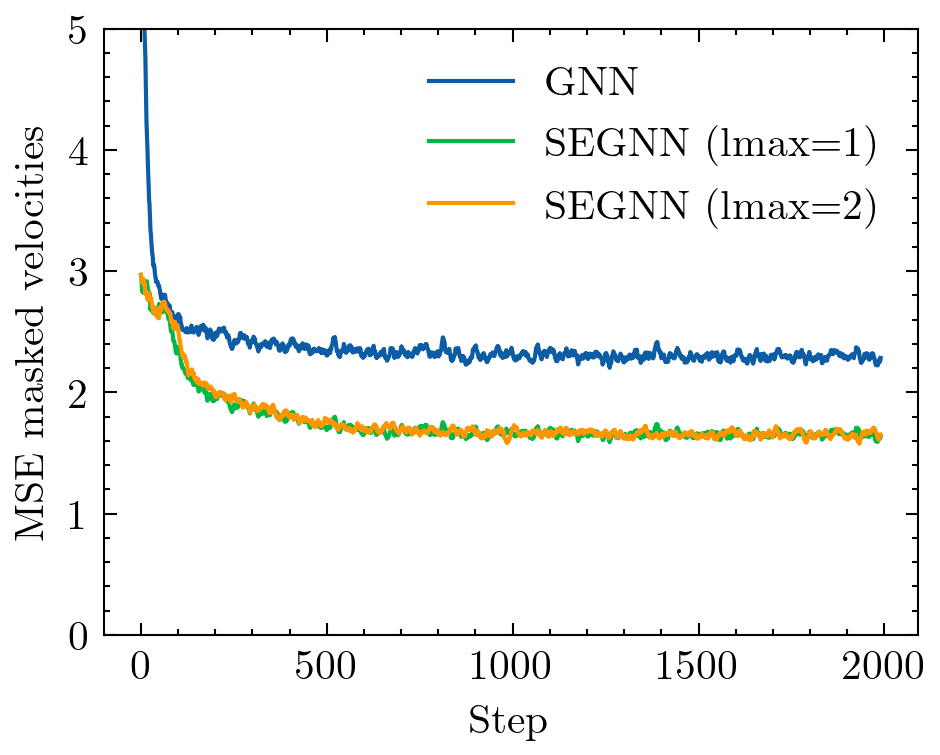

In [24]:
ds = 10
plt.plot(np.convolve(train_loss_gnn, np.ones(ds)/ds, mode='valid'), label="GNN")
plt.plot(np.convolve(train_loss_segnn, np.ones(ds)/ds, mode='valid'), label="SEGNN (lmax=1)")
plt.plot(np.convolve(train_loss_segnn_lmax2, np.ones(ds)/ds, mode='valid'), label="SEGNN (lmax=2)")
plt.ylabel('MSE masked velocities')
plt.xlabel('Step')
plt.ylim(0,5)
plt.legend()

In [25]:
# load parameters

In [26]:
# load params
# Visualize
x_batch, _ = next(val_iterator)
x_batch = jnp.array(x_batch)
key = jax.random.PRNGKey(0)
mask = jax.random.bernoulli(
    key,
    fraction_masked, 
    shape=(len(x_batch), x_batch.shape[1], 1)
)
x_batch_masked= x_batch.at[:, :, 3:6].set(
    jnp.where(mask, infill_value, x_batch[:, :, 3:6])
)
graph = fixed_build_graph(
    x_batch_masked,
)

In [27]:
graph

GraphsTuple(nodes=Array([[[ 0.2387473 ,  1.0723612 , -1.0504415 ,  3.0275035 ,
          0.9127717 ,  3.9738634 ],
        [-0.02318867, -0.470619  , -1.6777174 , -0.9455722 ,
          0.26116288, -0.33634084],
        [-1.467434  , -1.5658833 , -0.6978728 , -2.        ,
         -2.        , -2.        ],
        ...,
        [ 0.8136604 , -0.38417128,  1.219251  ,  0.27431667,
         -0.37986243, -0.40440804],
        [-0.4145628 , -1.1734166 ,  0.49166292,  0.65382606,
          0.6856346 , -0.32262278],
        [ 0.54511756, -1.6959616 , -0.9109226 , -0.9599607 ,
          0.20400065, -0.54368126]],

       [[ 0.6103923 ,  0.75344753,  1.2334902 , -2.4372163 ,
          3.937078  , -0.43161166],
        [-0.15520059, -0.23624144,  0.4745174 , -1.8014159 ,
         -0.6998372 ,  0.1870382 ],
        [-1.2399    , -0.10233575,  0.0439476 , -0.44383273,
          0.24185681,  0.28608727],
        ...,
        [ 1.325519  ,  1.6403006 ,  0.2618485 , -1.6931384 ,
          1.1820389 

In [28]:
ckpt_dir=str(Path(f'/global/u1/c/cuesta/eqnn-jax/benchmarks/galaxies/velocity_task/segnn_{training_set_size}'))

initial_state = initialize_state(segnn_model, graph, n_steps=n_steps)
restored_state = checkpoints.restore_checkpoint(ckpt_dir=ckpt_dir, target=initial_state)



segnn_pred = jax.jit(segnn_model.apply)(restored_state.params, graph)
segnn_pred = segnn_pred.nodes.array
segnn_pred = segnn_pred * std[3:6] + mean[3:6]

In [48]:
ckpt_dir=str(Path(f'/global/u1/c/cuesta/eqnn-jax/benchmarks/galaxies/velocity_task/gnn_{training_set_size}'))

initial_state = initialize_state(gnn, graph, n_steps=n_steps)
restored_state = checkpoints.restore_checkpoint(ckpt_dir=ckpt_dir, target=initial_state)



gnn_pred = jax.jit(gnn.apply)(restored_state.params, graph)


AttributeError: 'GraphsTuple' object has no attribute 'array'

In [51]:
gnn_pred.nodes.shape

(16, 5000, 3)

In [52]:
gnn_pred = gnn_pred.nodes
gnn_pred = gnn_pred * std[3:6] + mean[3:6]

In [31]:
segnn_pred[0,:100]

<tf.Tensor: shape=(100, 3), dtype=float32, numpy=
array([[  72.38166  ,    2.3870199, -146.25713  ],
       [ -18.354137 ,   92.422646 , -217.52069  ],
       [  98.92817  ,   81.29857  ,  181.82942  ],
       [ 181.46501  , -181.54565  , -153.86069  ],
       [ -27.697166 ,  -98.185745 ,   90.4228   ],
       [-197.0465   ,  394.36523  , -126.92254  ],
       [ 378.8426   , -110.55514  ,  154.50702  ],
       [ 210.06927  , -165.317    ,  -45.765804 ],
       [  31.92603  ,  124.562256 ,   27.2327   ],
       [ 254.51595  ,   -3.2161703, -320.40964  ],
       [ -70.50105  , -171.28459  , -122.77766  ],
       [  30.150269 , -151.63756  ,  -16.97649  ],
       [-359.49487  ,  182.56444  , -329.7341   ],
       [ 124.536316 ,  175.58748  ,  -76.92195  ],
       [ -20.411863 , -450.91467  , -141.58505  ],
       [  14.87548  ,  -52.911015 , -177.88828  ],
       [ 410.70844  ,  173.53506  ,  194.61758  ],
       [-174.9671   ,  122.852234 , -355.23962  ],
       [ 102.13702  ,  -86.1436 

In [32]:
# undo standarization
idx_plot = 2
mask_plot = np.array(mask[idx_plot, :, 0])
x_plot = np.array(x_batch[idx_plot] * std + mean)


In [33]:

x_plot_unmasked = np.array(x_plot[~mask_plot])
x_plot_masked = np.array(x_plot[mask_plot])

segnn_plot = np.array(segnn_pred[idx_plot][mask_plot])

In [53]:
gnn_plot = np.array(gnn_pred[idx_plot][mask_plot])

In [45]:
center = np.array(x_plot_unmasked[np.argmax(x_plot_unmasked[...,-1]),:3])
delta_r = 100.
l_min = center - delta_r 
l_max =  center + delta_r




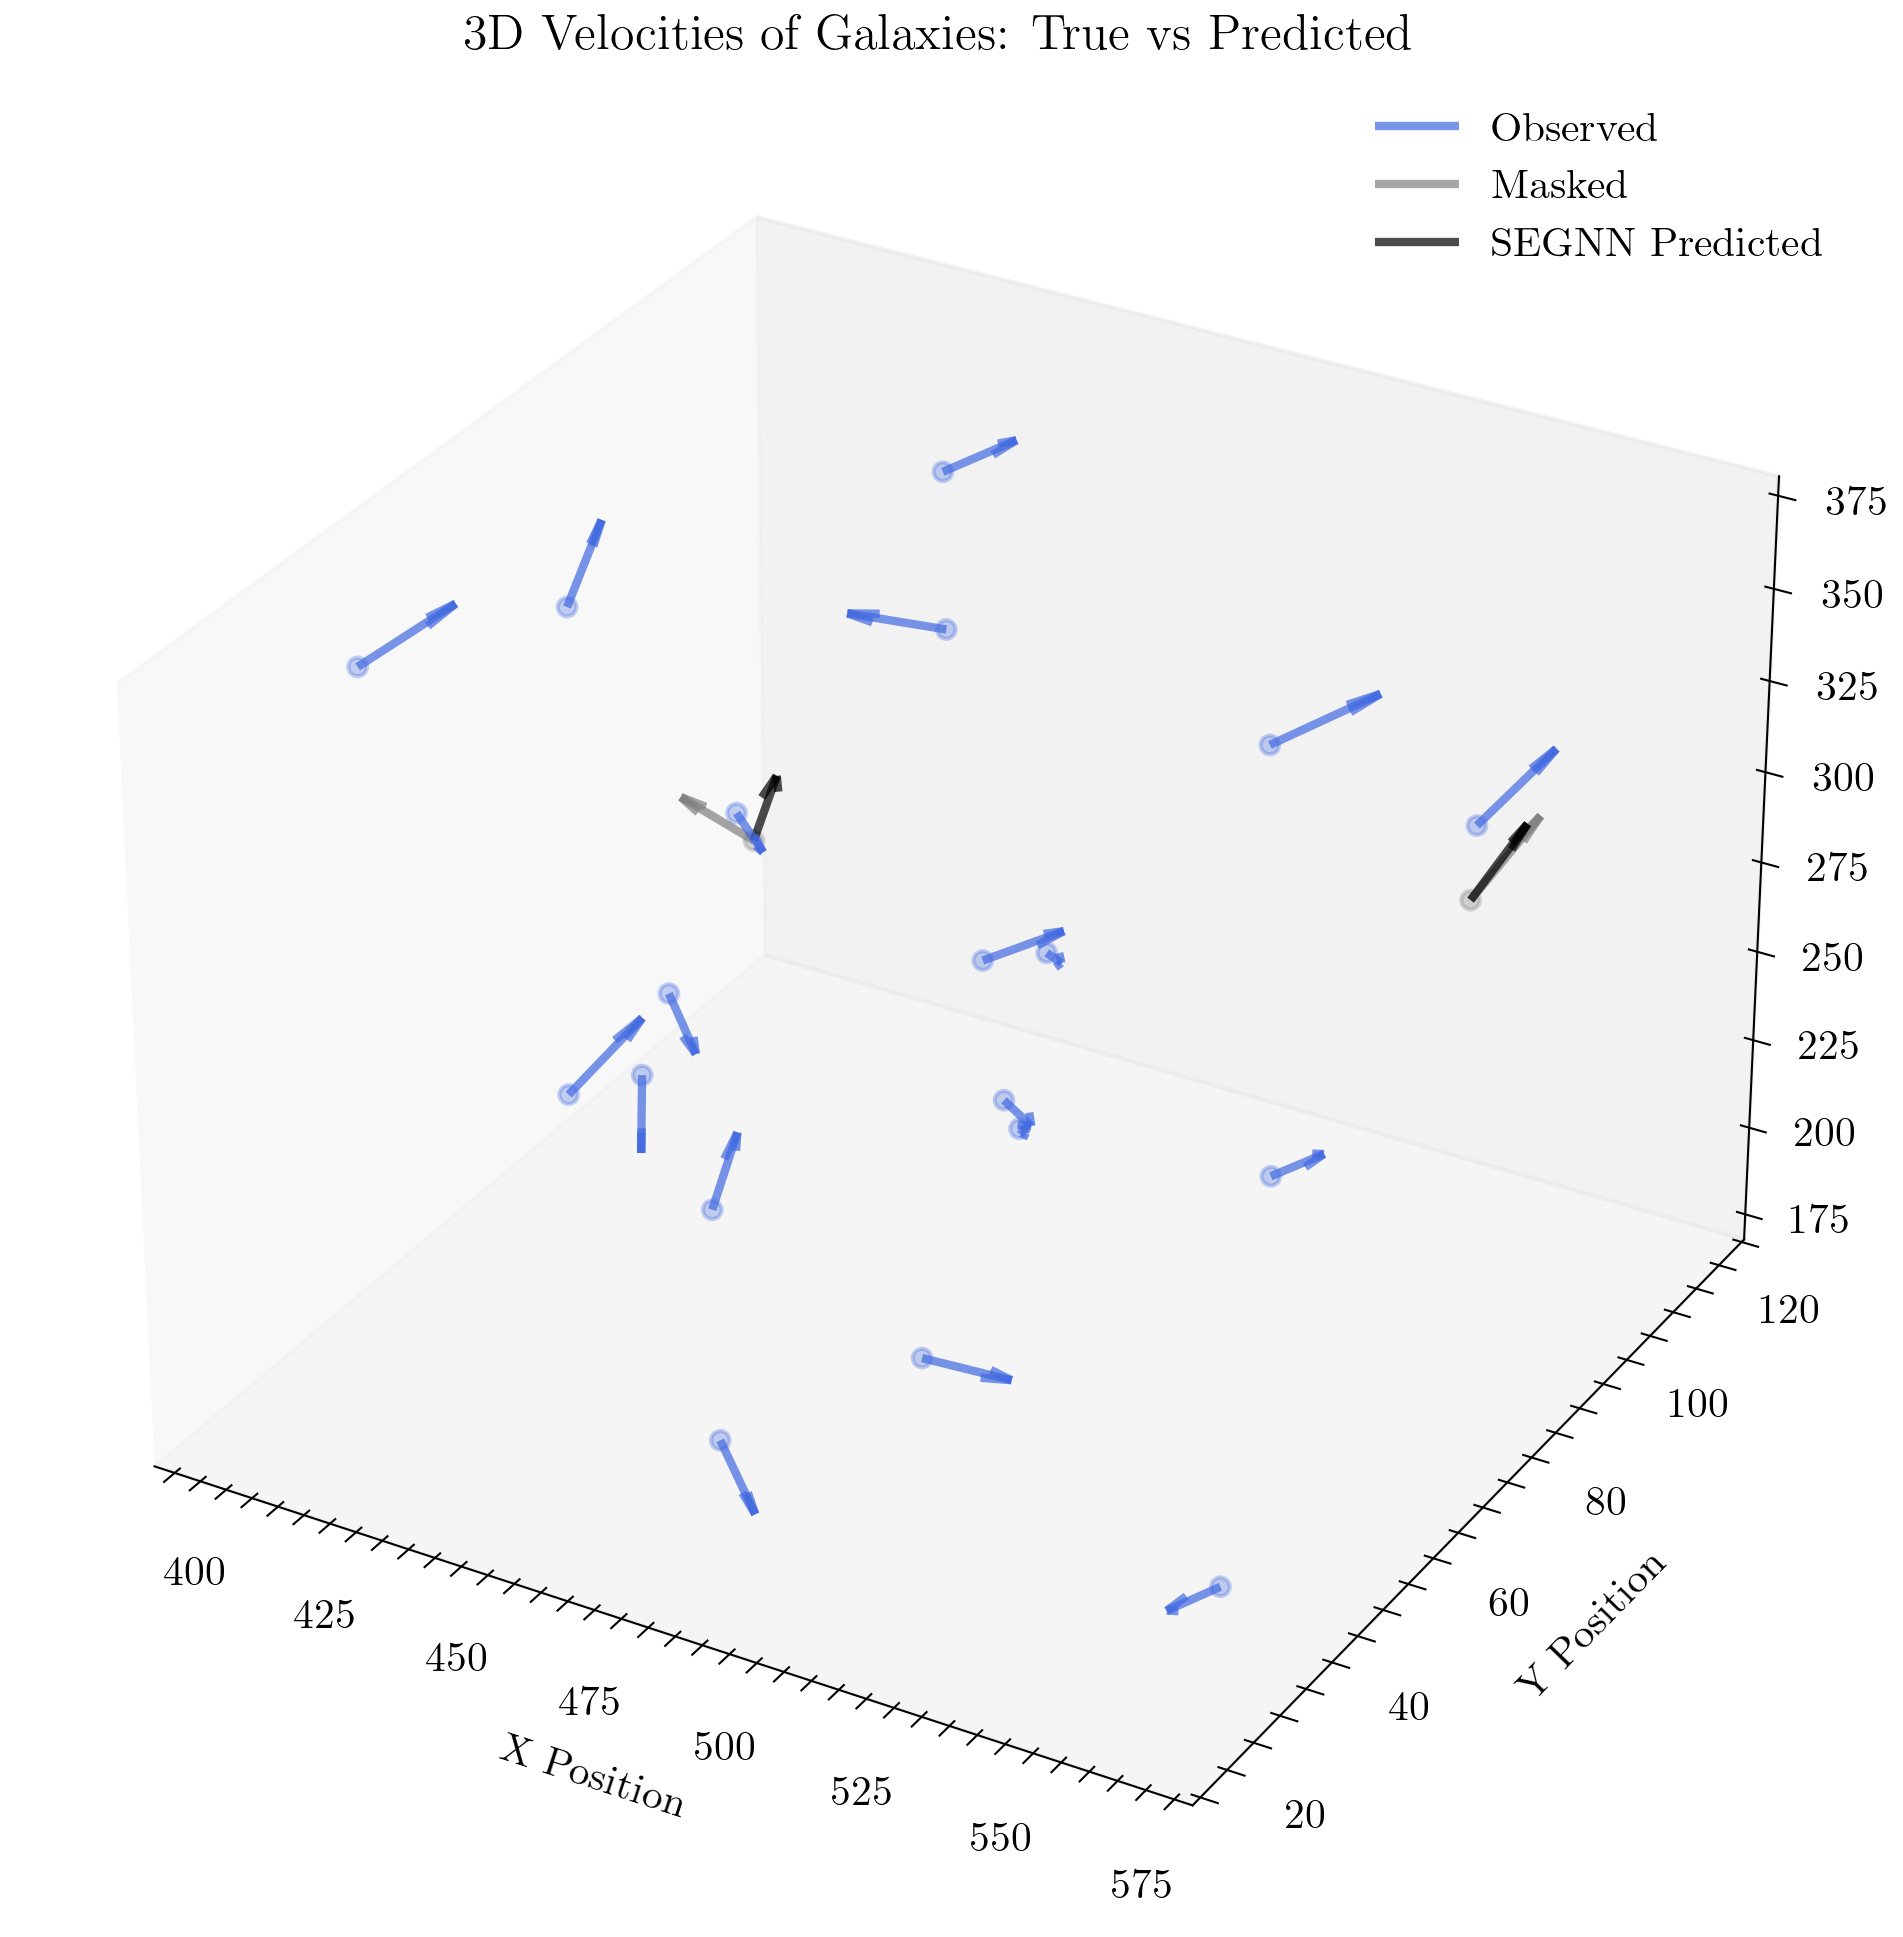

In [46]:
# Create a figure
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot true velocities
to_plot_unmasked = (
    x_plot_unmasked[:,0] > l_min[0]) & (x_plot_unmasked[:,0] < l_max[0]) & (x_plot_unmasked[:,1] > l_min[1]) & (x_plot_unmasked[:,1] < l_max[1]) & (x_plot_unmasked[:,2] > l_min[2]) & (x_plot_unmasked[:,2] < l_max[2]
)
ax.quiver(
    x_plot_unmasked[to_plot_unmasked, 0],
    x_plot_unmasked[to_plot_unmasked, 1],
    x_plot_unmasked[to_plot_unmasked, 2],
    x_plot_unmasked[to_plot_unmasked, 3],
    x_plot_unmasked[to_plot_unmasked, 4],
    x_plot_unmasked[to_plot_unmasked, 5],
        color='royalblue', length=15, normalize=True, label='Observed', alpha=0.7, linewidths=2)
ax.scatter(
    x_plot_unmasked[to_plot_unmasked, 0],
    x_plot_unmasked[to_plot_unmasked, 1],
    x_plot_unmasked[to_plot_unmasked, 2],
    color='royalblue', s=20, alpha=0.3)
to_plot_masked = (
    x_plot_masked[:,0] > l_min[0]) & (x_plot_masked[:,0] < l_max[0]) & (x_plot_masked[:,1] > l_min[1]) & (x_plot_masked[:,1] < l_max[1]) & (x_plot_masked[:,2] > l_min[2]) & (x_plot_masked[:,2] < l_max[2]
)

ax.quiver(
    x_plot_masked[to_plot_masked, 0],
    x_plot_masked[to_plot_masked, 1],
    x_plot_masked[to_plot_masked, 2],
    x_plot_masked[to_plot_masked, 3],
    x_plot_masked[to_plot_masked, 4],
    x_plot_masked[to_plot_masked, 5],
        color='gray', length=15, normalize=True, label='Masked', alpha=0.7, linewidths=2)
ax.scatter(
    x_plot_masked[to_plot_masked, 0],
    x_plot_masked[to_plot_masked, 1],
    x_plot_masked[to_plot_masked, 2],
    color='gray', s=20, alpha=0.3)
ax.quiver(
    x_plot_masked[to_plot_masked, 0],
    x_plot_masked[to_plot_masked, 1],
    x_plot_masked[to_plot_masked, 2],
    segnn_plot[to_plot_masked, 0],
    segnn_plot[to_plot_masked, 1],
    segnn_plot[to_plot_masked, 2],
        color='black', length=15, normalize=True, label='SEGNN Predicted', alpha=0.7, linewidths=2)

ax.quiver(
    x_plot_masked[to_plot_masked, 0],
    x_plot_masked[to_plot_masked, 1],
    x_plot_masked[to_plot_masked, 2],
    gnn_plot[to_plot_masked, 0],
    gnn_plot[to_plot_masked, 1],
    gnn_plot[to_plot_masked, 2],
        color='black', length=15, normalize=True, label='SEGNN Predicted', alpha=0.7, linewidths=2)


#ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], color='royalblue', s=20, alpha=0.3)
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')
ax.set_title('3D Velocities of Galaxies: True vs Predicted')
ax.set_facecolor('white')
ax.grid(False)
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.zaxis.label.set_color('black')
ax.legend()


# Customize plot
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')
ax.set_title('3D Velocities of Galaxies: True vs Predicted')
ax.set_facecolor('white')
ax.grid(False)
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.zaxis.label.set_color('black')
ax.legend()

In [31]:
def get_test_loss(model, params, test_iterator):
    n_steps = len(val_dataset) // batch_size
    val_loss = 0.
    key = jax.random.PRNGKey(0)
    for _ in range(n_steps):
        key, subkey = jax.random.split(key)
        x_batch, _ = next(test_iterator)
        x_batch = jnp.array(x_batch)
        mask = jax.random.bernoulli(
            key,
            fraction_masked, 
            shape=(len(x_batch), x_batch.shape[1], 1)
        )
        x_batch_masked= x_batch.at[:, :, 3:6].set(
            jnp.where(mask, infill_value, x_batch[:, :, 3:6])
        )
        graph = fixed_build_graph(
            x_batch_masked,
        )
        pred = jax.jit(model.apply)(params, graph)
        pred = pred.nodes
        if isinstance(pred, e3nn.IrrepsArray):
            pred = pred.array
        val_loss += loss_mse(pred, x_batch, mask)
    return val_loss / n_steps

In [32]:
loss_gnn = evaluate(gnn, params_gnn, val_iterator)

UnboundLocalError: local variable 'key' referenced before assignment

In [ ]:
loss_segnn = evaluate(segnn_model, params_segnn, val_iterator)

In [ ]:

loss_segnn_lmax2 = evaluate(segnn_model_lmax2, params_segnn_lmax2, val_iterator)

In [28]:
# Visualize
x_batch, _ = next(val_iterator)
x_batch = jnp.array(x_batch)
key = jax.random.PRNGKey(0)
mask = jax.random.bernoulli(
    key,
    fraction_masked, 
    shape=(len(x_batch), x_batch.shape[1], 1)
)
x_batch_masked= x_batch.at[:, :, 3:6].set(
    jnp.where(mask, infill_value, x_batch[:, :, 3:6])
)
graph = fixed_build_graph(
    x_batch_masked,
)
#gnn_pred = jax.jit(gnn.apply)(params_gnn, graph)
segnn_pred = jax.jit(segnn_model.apply)(params_segnn, graph)

2024-05-23 09:30:31.508296: W external/xla/xla/service/hlo_rematerialization.cc:2948] Can't reduce memory use below -4.04GiB (-4333881624 bytes) by rematerialization; only reduced to 17.88GiB (19200000000 bytes), down from 17.88GiB (19200000000 bytes) originally
2024-05-23 09:30:31.508477: W external/xla/xla/service/hlo_rematerialization.cc:2948] Can't reduce memory use below -4.04GiB (-4333881624 bytes) by rematerialization; only reduced to 17.88GiB (19200000000 bytes), down from 17.88GiB (19200000000 bytes) originally
2024-05-23 09:30:31.508511: W external/xla/xla/service/hlo_rematerialization.cc:2948] Can't reduce memory use below -4.04GiB (-4333881624 bytes) by rematerialization; only reduced to 17.88GiB (19200000000 bytes), down from 17.88GiB (19200000000 bytes) originally
2024-05-23 09:30:31.508535: W external/xla/xla/service/hlo_rematerialization.cc:2948] Can't reduce memory use below -4.04GiB (-4333881624 bytes) by rematerialization; only reduced to 17.88GiB (19200000000 bytes)

: 

In [ ]:
mask